<a href="https://colab.research.google.com/github/juan-scholarium/pycon2020/blob/main/pycon2020-diabetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning Inception v3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!nvidia-smi

Thu Oct 15 11:44:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, optimizers, losses, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import utils
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [ ]:
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

Tensorflow version:  2.3.0
Keras version:  2.4.0


In [ ]:
base_dir = "/content/drive/My Drive/dataset/aptos2019-balance-set"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")
save_dir = os.path.join(base_dir, "models")

In [ ]:
image_shape = (299, 299, 3)
batch_size = 16

In [ ]:
def plot_training(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training acc")
    plt.plot(epochs, val_acc, label="valid acc")
    plt.title("Training & valid Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="valid loss")
    plt.title("Training & valid Loss")
    plt.legend()

    plt.show()

# Preparation

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=180,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=[0.9, 1.2],
    fill_mode="constant",
    data_format="channels_last",
)

test_datagen = image.ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
)

Found 750 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()
]

In [ ]:
my_callbacks = [
    callbacks.CSVLogger(os.path.join(save_dir, "pycon2020-dr.csv"), separator=",", append=True),
    # callbacks.ModelCheckpoint(os.path.join(save_dir, "model.{epoch:02d}-{val_loss:.2f}.h5"), monitor="val_los", mode="min"),
    # callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=1e-8),
    # callbacks.TensorBoard(log_dir="keras_log_dir"),
]

# Check training dataset

In [ ]:
train_generator[0][0].shape

(16, 299, 299, 3)

In [ ]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

1

In [ ]:
train_generator.filepaths[image_idx]

'/content/drive/My Drive/dataset/aptos2019-balance-set/train/1_mild/c7b622ec8104.png'

In [ ]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(16, 299, 299, 3)
(16, 5)


<function matplotlib.pyplot.show>

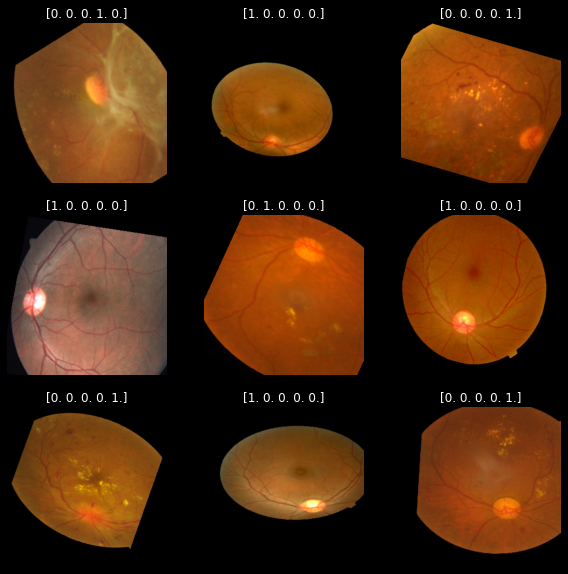

In [ ]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis("off")

plt.show

# Check validation dataset

In [ ]:
validation_generator[0][0].shape

(16, 299, 299, 3)

In [ ]:
# check image dataset
image_idx = validation_generator.index_array[1]
validation_generator.labels[image_idx]

4

In [ ]:
validation_generator.filepaths[image_idx]

'/content/drive/My Drive/dataset/aptos2019-balance-set/valid/4_proliferative/789434d095d1.png'

In [ ]:
valid_images_7, valid_labels_7 = validation_generator[3]
print(train_images_7.shape)
print(train_labels_7.shape)

(16, 299, 299, 3)
(16, 5)


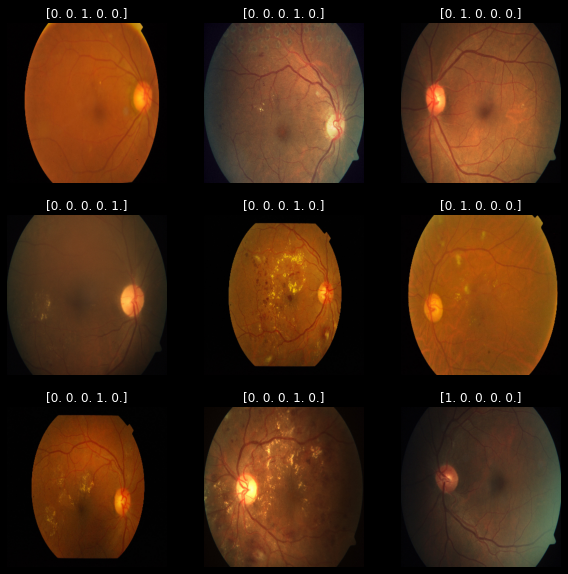

In [ ]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis("off")

# End to end learning

In [ ]:
conv_base = InceptionV3(
    include_top=False,
    weights=None,
    input_shape=image_shape,
)

conv_base.trainable=True
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
utils.plot_model(
    conv_base,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=True)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer="l2", bias_regularizer="l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=my_metrics,
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    tf_op_layer_Sub[0][0]            
_______________________________________________________________________________________

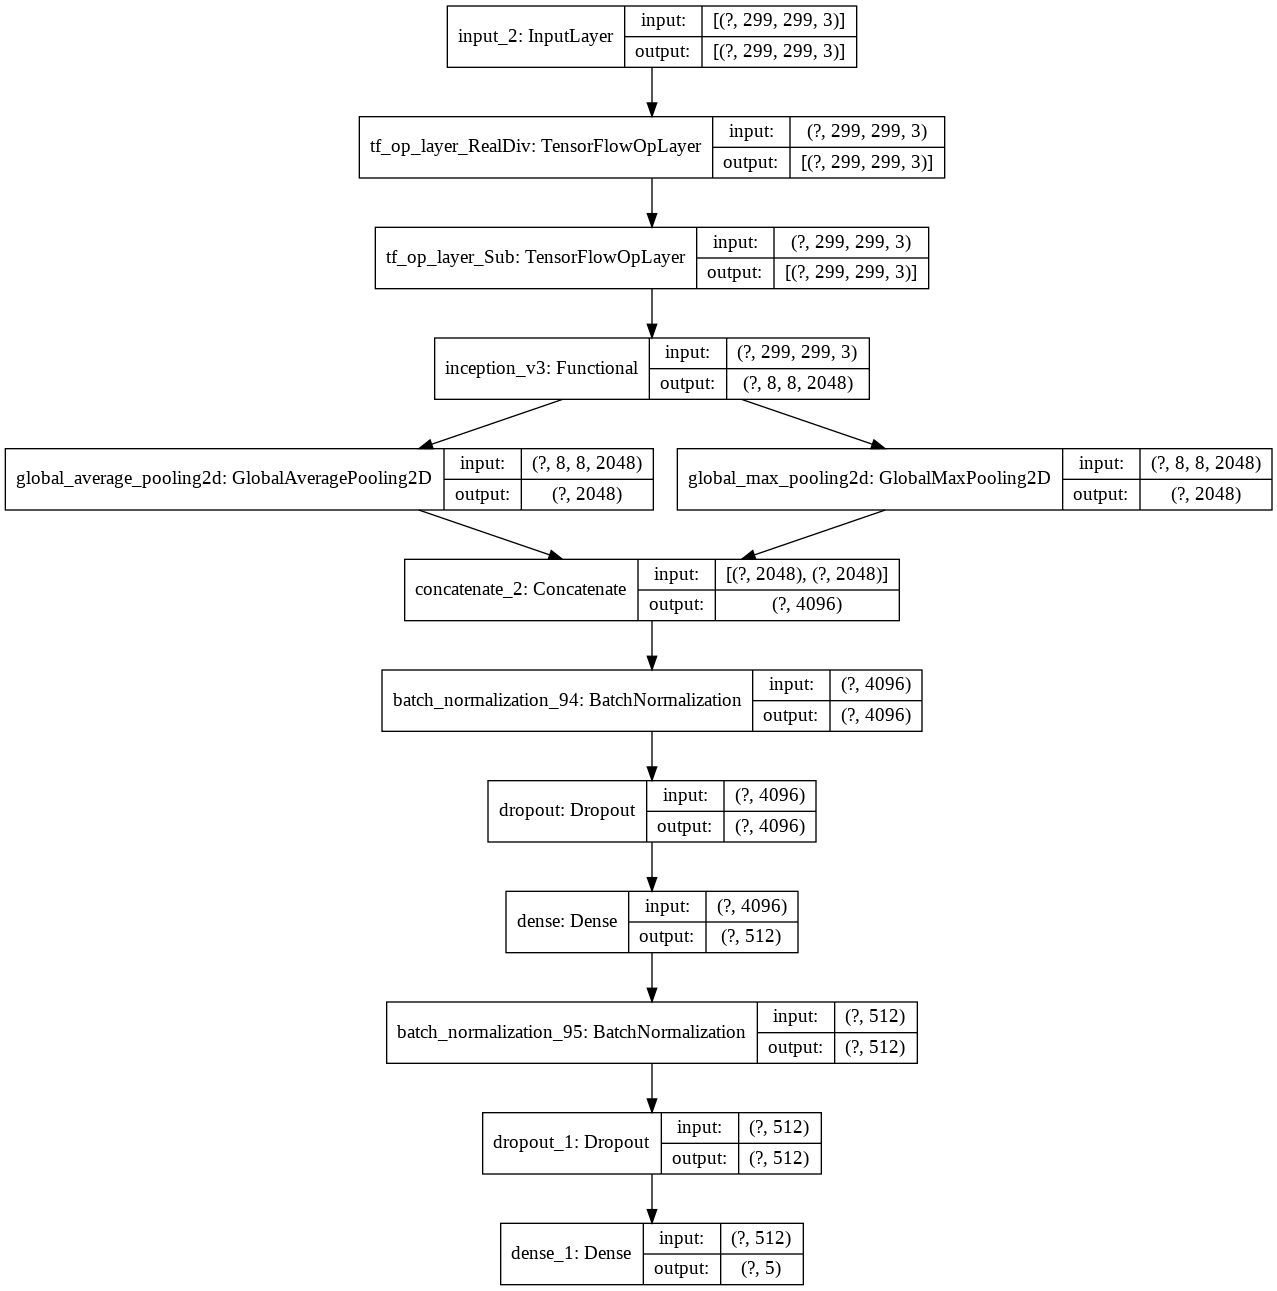

In [ ]:
utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=my_callbacks,
)

Epoch 1/100
47/47 [==============================] - 623s 13s/step - loss: 10.2928 - categorical_accuracy: 0.2653 - precision: 0.2692 - recall: 0.2013 - auc: 0.5669 - val_loss: 9.8790 - val_categorical_accuracy: 0.2500 - val_precision: 0.5625 - val_recall: 0.0900 - val_auc: 0.5813
Epoch 2/100
47/47 [==============================] - 141s 3s/step - loss: 9.5021 - categorical_accuracy: 0.3040 - precision: 0.3165 - recall: 0.2587 - auc: 0.6158 - val_loss: 9.1231 - val_categorical_accuracy: 0.3200 - val_precision: 0.4194 - val_recall: 0.1300 - val_auc: 0.6313
Epoch 3/100
47/47 [==============================] - 141s 3s/step - loss: 8.7734 - categorical_accuracy: 0.3400 - precision: 0.3515 - recall: 0.3093 - auc: 0.6212 - val_loss: 8.4036 - val_categorical_accuracy: 0.3400 - val_precision: 0.4576 - val_recall: 0.2700 - val_auc: 0.6349
Epoch 4/100
47/47 [==============================] - 141s 3s/step - loss: 8.0830 - categorical_accuracy: 0.3507 - precision: 0.3643 - recall: 0.3187 - auc: 0.

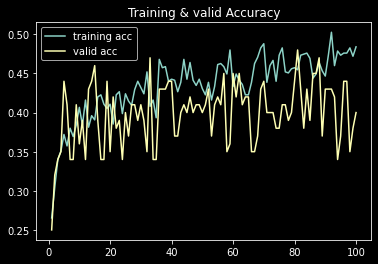

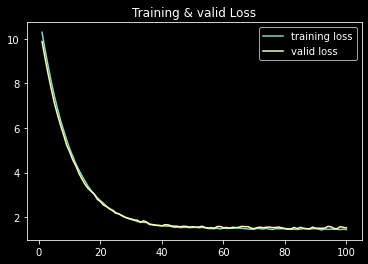

In [ ]:
plot_training(history)

In [ ]:
model.save(os.path.join(save_dir, "end-to-end-100.h5"))

## Evaluate Model

In [ ]:
model.evaluate(validation_generator, verbose=1)

7/7 [==============================] - 13s 2s/step - loss: 1.5238 - categorical_accuracy: 0.4200 - precision: 0.4242 - recall: 0.4200 - auc: 0.6598


[1.5238009691238403,
 0.41999998688697815,
 0.42424243688583374,
 0.41999998688697815,
 0.6597874164581299]

In [ ]:
y_true = list()

for idx in range(len(validation_generator.labels)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [ ]:
y_true[:10]

[3, 3, 2, 2, 2, 4, 4, 3, 1, 4]

In [ ]:
y_pred_prob = model.predict(validation_generator)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

In [ ]:
y_pred[:10]

[4, 3, 3, 3, 4, 2, 2, 0, 2, 1]

In [ ]:
print(classification_report(y_true, y_pred, target_names=["normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.65      0.55      0.59        20
         mild       0.40      0.40      0.40        20
     moderate       0.43      0.45      0.44        20
       severe       0.33      0.35      0.34        20
proliferative       0.24      0.25      0.24        20

     accuracy                           0.40       100
    macro avg       0.41      0.40      0.40       100
 weighted avg       0.41      0.40      0.40       100



# Transfer learning

In [ ]:
conv_base = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
)

conv_base.trainable=False
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_192[0][0]    
_______________________________________________________________________________________

In [ ]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=True)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer="l2", bias_regularizer="l2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=my_metrics,
)

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_RealDiv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    tf_op_layer_Sub_2[0][0]          
_______________________________________________________________________________________

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=my_callbacks,
)

Epoch 1/30
47/47 [==============================] - 139s 3s/step - loss: 10.3001 - categorical_accuracy: 0.3664 - precision: 0.3950 - recall: 0.3058 - auc: 0.6696 - val_loss: 10.0913 - val_categorical_accuracy: 0.2000 - val_precision: 0.1961 - val_recall: 0.1000 - val_auc: 0.5797
Epoch 2/30
47/47 [==============================] - 133s 3s/step - loss: 9.6223 - categorical_accuracy: 0.4667 - precision: 0.4939 - recall: 0.4320 - auc: 0.7511 - val_loss: 9.4462 - val_categorical_accuracy: 0.3200 - val_precision: 0.3594 - val_recall: 0.2300 - val_auc: 0.6587
Epoch 3/30
47/47 [==============================] - 136s 3s/step - loss: 9.0123 - categorical_accuracy: 0.5133 - precision: 0.5282 - recall: 0.4867 - auc: 0.7853 - val_loss: 8.8612 - val_categorical_accuracy: 0.3900 - val_precision: 0.3803 - val_recall: 0.2700 - val_auc: 0.7035
Epoch 4/30
47/47 [==============================] - 135s 3s/step - loss: 8.4800 - categorical_accuracy: 0.5173 - precision: 0.5480 - recall: 0.5027 - auc: 0.7960

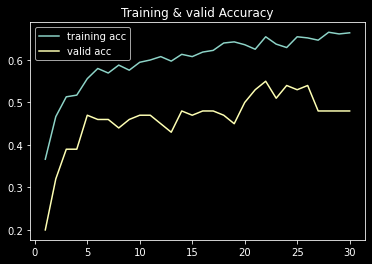

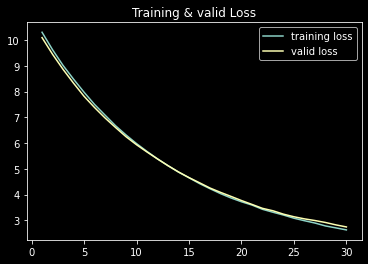

In [ ]:
plot_training(history)

In [ ]:
model.save(os.path.join(save_dir, "transfer-learning-100.h5"))

## Evaluate Model

In [ ]:
model.evaluate(validation_generator, verbose=1)

7/7 [==============================] - 13s 2s/step - loss: 2.7452 - categorical_accuracy: 0.4800 - precision: 0.5000 - recall: 0.4600 - auc: 0.7756


[2.7451703548431396,
 0.47999998927116394,
 0.5,
 0.46000000834465027,
 0.7756374478340149]

In [ ]:
y_true = list()

for idx in range(len(validation_generator.labels)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [ ]:
y_true[:10]

[0, 2, 2, 1, 0, 4, 1, 1, 0, 1]

In [ ]:
y_pred_prob = model.predict(validation_generator)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

In [ ]:
y_pred[:10]

[0, 1, 1, 0, 0, 4, 1, 1, 0, 0]

In [ ]:
print(classification_report(y_true, y_pred, target_names=["normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.62      1.00      0.77        20
         mild       0.46      0.30      0.36        20
     moderate       0.25      0.10      0.14        20
       severe       0.54      0.70      0.61        20
proliferative       0.29      0.30      0.29        20

     accuracy                           0.48       100
    macro avg       0.43      0.48      0.44       100
 weighted avg       0.43      0.48      0.44       100



# Fine Tune

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_5 False
conv2d_188 False
batch_normalization_192 False
activation_188 False
conv2d_189 False
batch_normalization_193 False
activation_189 False
conv2d_190 False
batch_normalization_194 False
activation_190 False
max_pooling2d_8 False
conv2d_191 False
batch_normalization_195 False
activation_191 False
conv2d_192 False
batch_normalization_196 False
activation_192 False
max_pooling2d_9 False
conv2d_196 False
batch_normalization_200 False
activation_196 False
conv2d_194 False
conv2d_197 False
batch_normalization_198 False
batch_normalization_201 False
activation_194 False
activation_197 False
average_pooling2d_18 False
conv2d_193 False
conv2d_195 False
conv2d_198 False
conv2d_199 False
batch_normalization_197 False
batch_normalization_199 False
batch_normalization_202 False
batch_normalization_203 False
activation_193 False
activation_195 False
activation_198 False
activation_199 False
mixed0 False
conv2d_203 False
batch_normalization_207 False
activation_203 False
conv2d_201 False
c

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "mixed9":
        set_trainable = True
    
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_5 False
conv2d_188 False
batch_normalization_192 False
activation_188 False
conv2d_189 False
batch_normalization_193 False
activation_189 False
conv2d_190 False
batch_normalization_194 False
activation_190 False
max_pooling2d_8 False
conv2d_191 False
batch_normalization_195 False
activation_191 False
conv2d_192 False
batch_normalization_196 False
activation_192 False
max_pooling2d_9 False
conv2d_196 False
batch_normalization_200 False
activation_196 False
conv2d_194 False
conv2d_197 False
batch_normalization_198 False
batch_normalization_201 False
activation_194 False
activation_197 False
average_pooling2d_18 False
conv2d_193 False
conv2d_195 False
conv2d_198 False
conv2d_199 False
batch_normalization_197 False
batch_normalization_199 False
batch_normalization_202 False
batch_normalization_203 False
activation_193 False
activation_195 False
activation_198 False
activation_199 False
mixed0 False
conv2d_203 False
batch_normalization_207 False
activation_203 False
conv2d_201 False
c

In [ ]:
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-6),
    metrics=my_metrics,
)

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_RealDiv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    tf_op_layer_Sub_2[0][0]          
_______________________________________________________________________________________

In [ ]:
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=validation_generator,
    callbacks=my_callbacks,
)

Epoch 1/70
47/47 [==============================] - 143s 3s/step - loss: 2.6232 - categorical_accuracy: 0.6176 - precision: 0.6300 - recall: 0.6071 - auc: 0.8463 - val_loss: 2.8051 - val_categorical_accuracy: 0.4400 - val_precision: 0.4468 - val_recall: 0.4200 - val_auc: 0.7225
Epoch 2/70
47/47 [==============================] - 137s 3s/step - loss: 2.6032 - categorical_accuracy: 0.6573 - precision: 0.6653 - recall: 0.6467 - auc: 0.8673 - val_loss: 2.7659 - val_categorical_accuracy: 0.4800 - val_precision: 0.4945 - val_recall: 0.4500 - val_auc: 0.7623
Epoch 3/70
47/47 [==============================] - 137s 3s/step - loss: 2.6246 - categorical_accuracy: 0.6333 - precision: 0.6409 - recall: 0.6187 - auc: 0.8516 - val_loss: 2.7581 - val_categorical_accuracy: 0.4700 - val_precision: 0.4894 - val_recall: 0.4600 - val_auc: 0.7724
Epoch 4/70
47/47 [==============================] - 136s 3s/step - loss: 2.6233 - categorical_accuracy: 0.6280 - precision: 0.6434 - recall: 0.6133 - auc: 0.8518 -

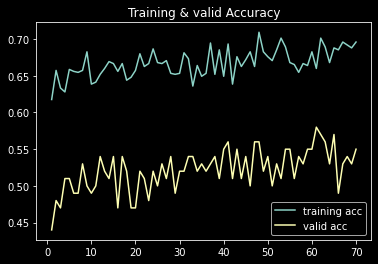

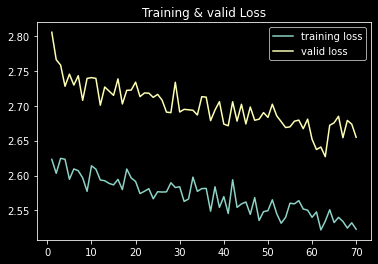

In [ ]:
plot_training(history)

In [ ]:
model.save(os.path.join(save_dir, "fine-tuning-100.h5"))

## Evaluate Model

In [ ]:
model.evaluate(validation_generator, verbose=1)

7/7 [==============================] - 12s 2s/step - loss: 2.6674 - categorical_accuracy: 0.5400 - precision: 0.5474 - recall: 0.5200 - auc: 0.8111


[2.6673617362976074,
 0.5400000214576721,
 0.5473684072494507,
 0.5199999809265137,
 0.81107497215271]

In [ ]:
y_true = list()

for idx in range(len(validation_generator.labels)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [ ]:
y_true[:10]

[1, 0, 0, 1, 0, 0, 4, 1, 4, 4]

In [ ]:
y_pred_prob = model.predict(validation_generator)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

In [ ]:
y_pred[:10]

[2, 0, 0, 1, 0, 0, 3, 3, 3, 1]

In [ ]:
print(classification_report(y_true, y_pred, target_names=["normal", "mild", "moderate", "severe", "proliferative"]))

               precision    recall  f1-score   support

       normal       0.79      0.95      0.86        20
         mild       0.53      0.50      0.51        20
     moderate       0.38      0.30      0.33        20
       severe       0.50      0.60      0.55        20
proliferative       0.29      0.25      0.27        20

     accuracy                           0.52       100
    macro avg       0.50      0.52      0.51       100
 weighted avg       0.50      0.52      0.51       100

